In [1]:
# BEST TO USE venv Python 3.11.9

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import ast

import textwrap

# 1. Support Functions

In [2]:
from plotting import visualize_all_activities_with_detailed_biosphere

# 2. Loading Scenarios

In [ ]:
ssp1_baseline_results_df = pd.read_csv('./outputs/combined_results/combined_results_remindSSP1_baseline.csv')
ssp1_vsi_results_df = pd.read_csv('./outputs/combined_results/combined_results_remindSSP1_VSI.csv')
ssp1_vsi_interpolated_results_df = pd.read_csv('./outputs/combined_results/combined_results_remindSSP1_VSI_interpolated.csv')

# 3. Visualisation of contributions

## 3.1. Lithium subsystem

Total Activities: 3


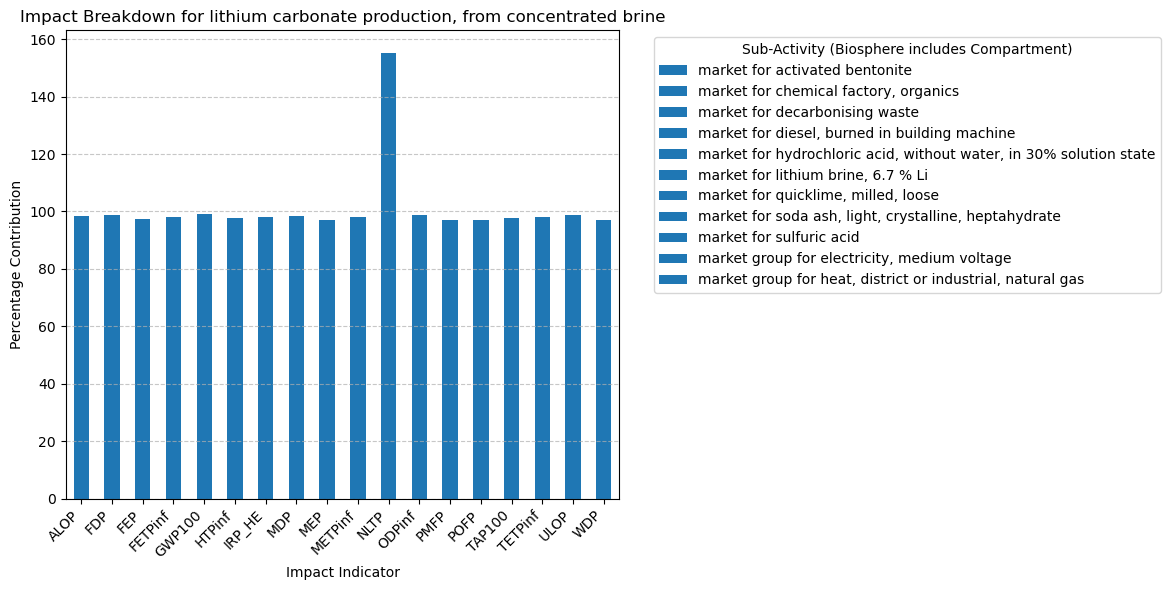

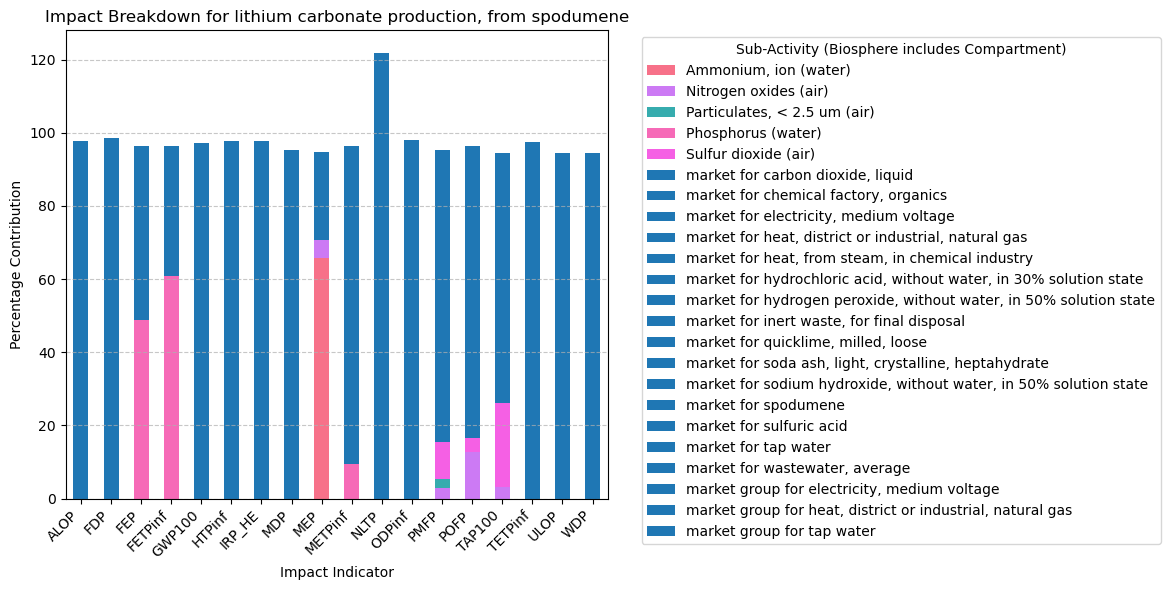

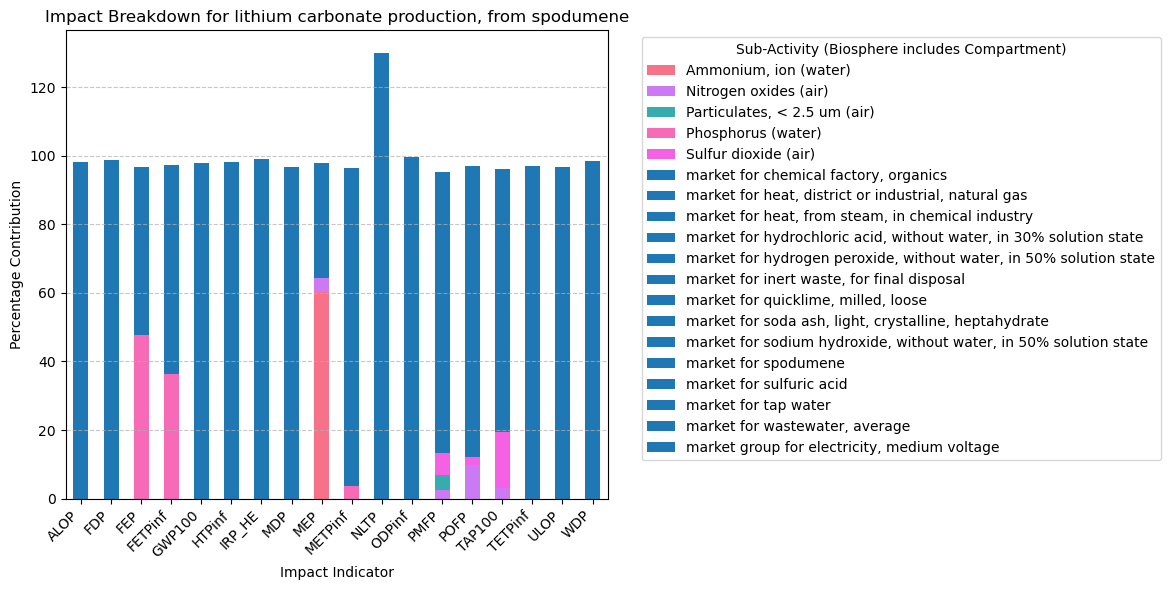

In [3]:
csv_file_path = "contribution_analysis/EFcontributions_lithium.csv" 

# Run the function to generate plots for all activities with grid
visualize_all_activities_with_detailed_biosphere(csv_file_path)

## 3.2. Nickel subsystem

Total Activities: 8


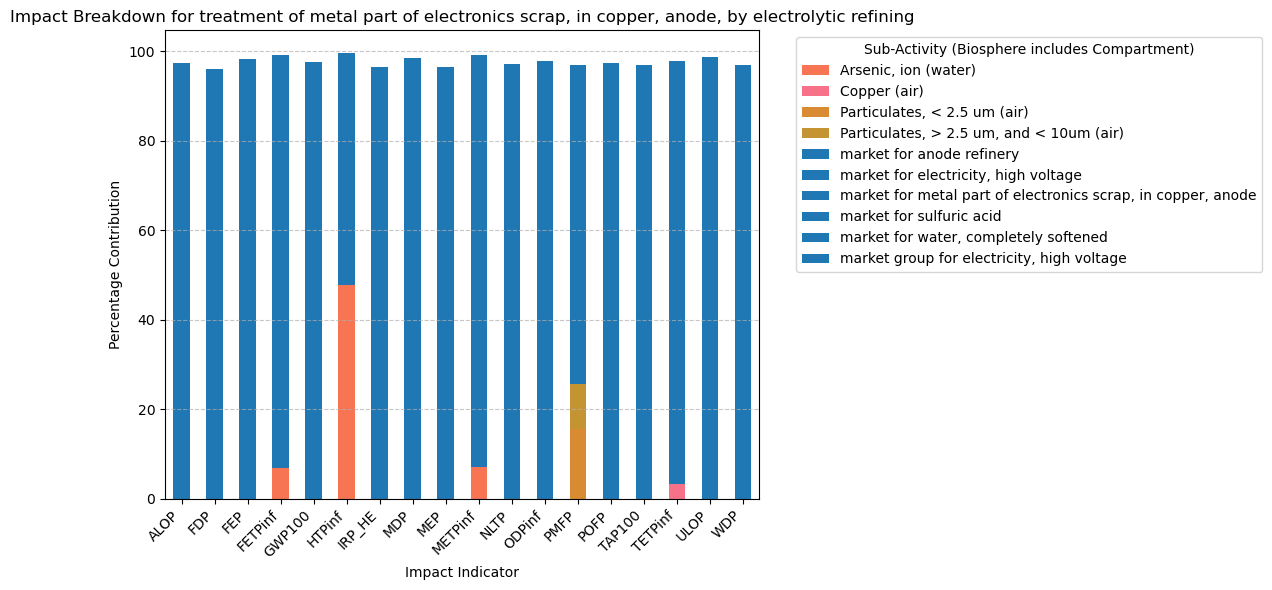

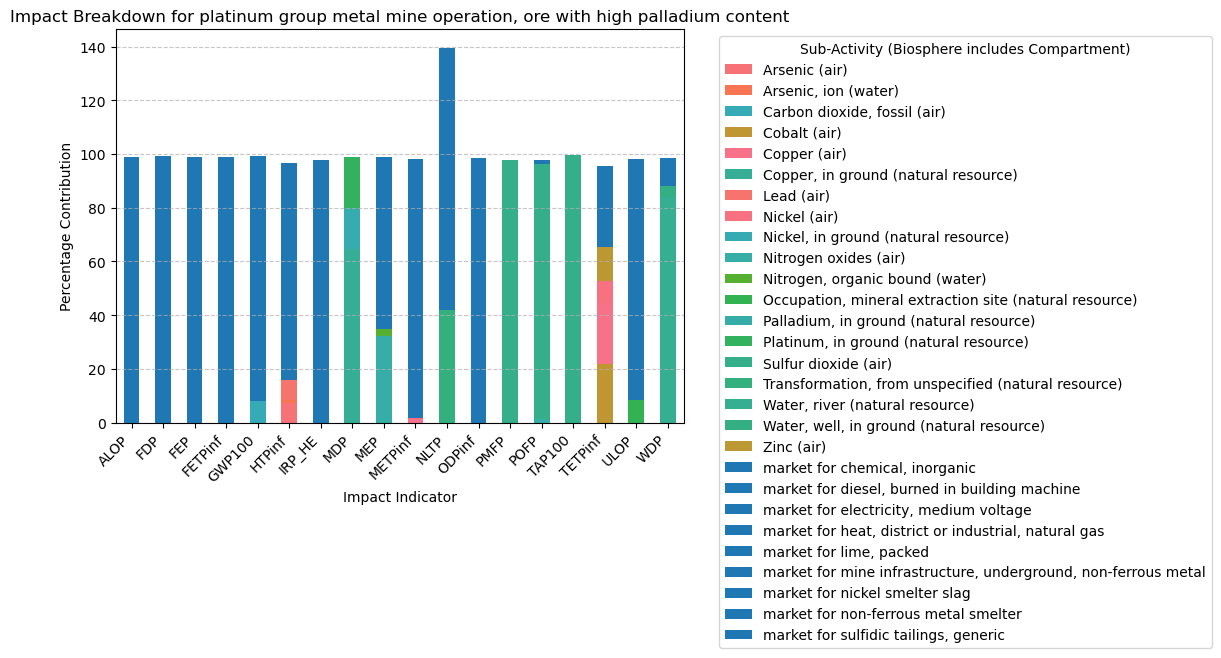

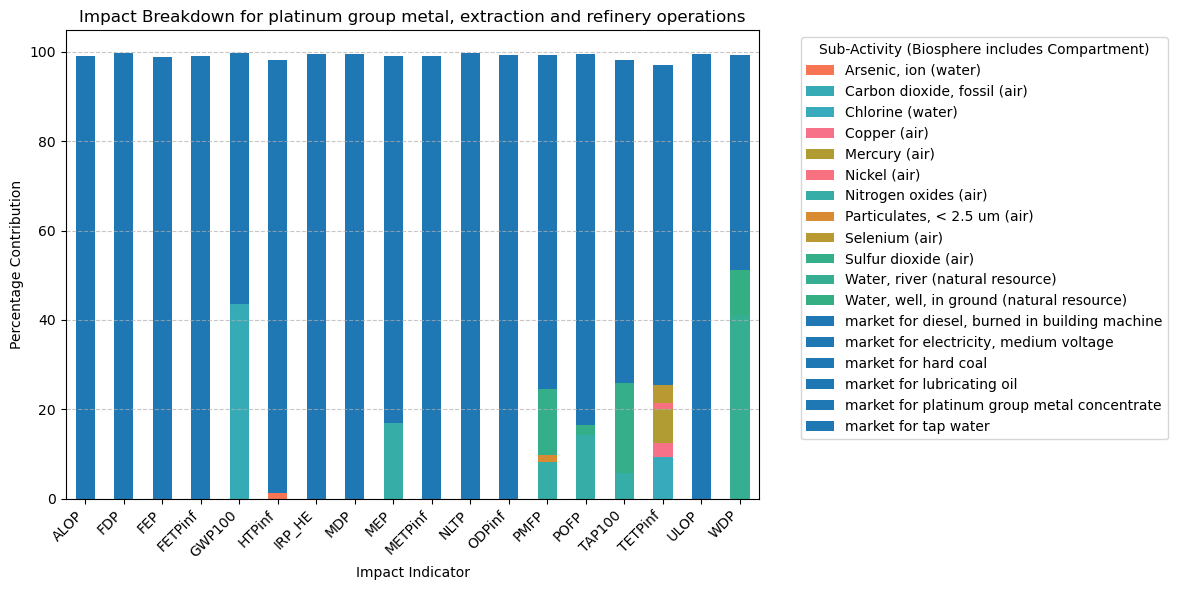

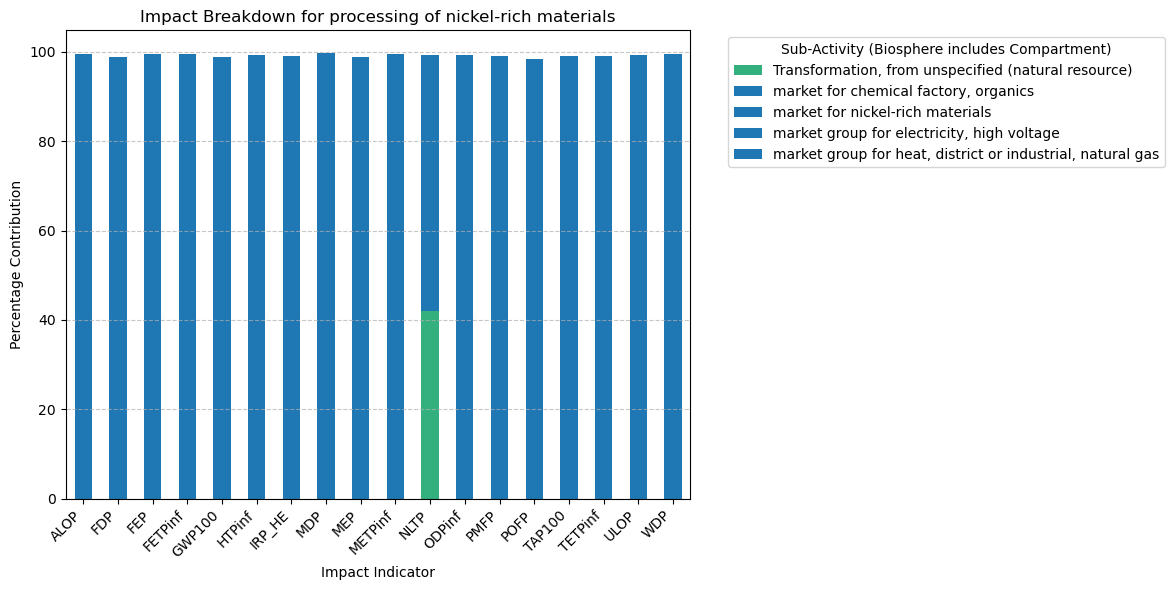

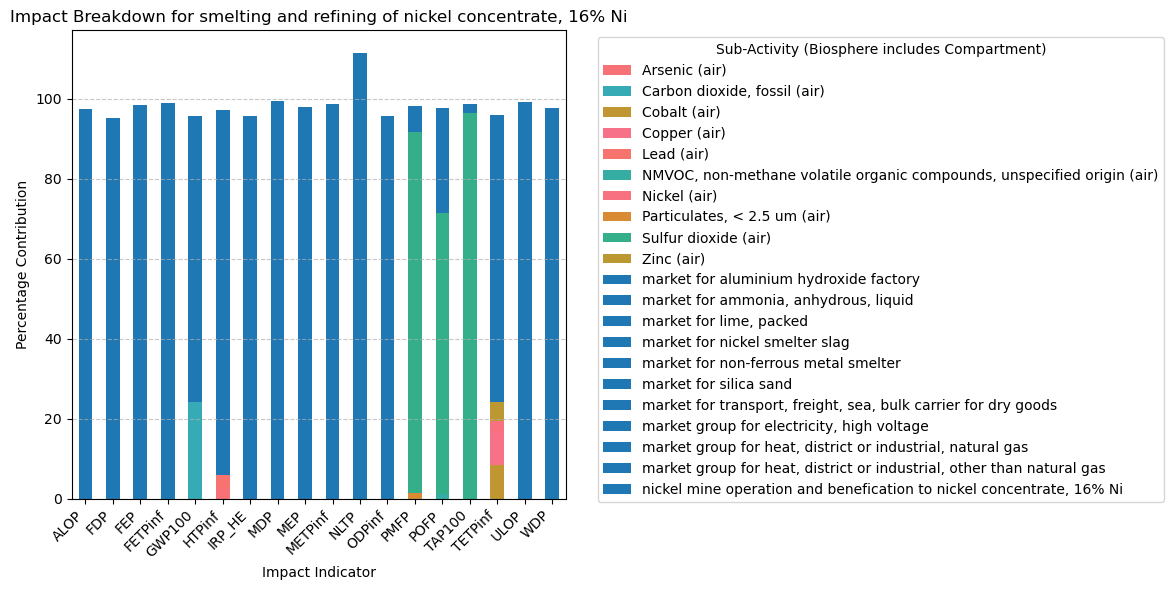

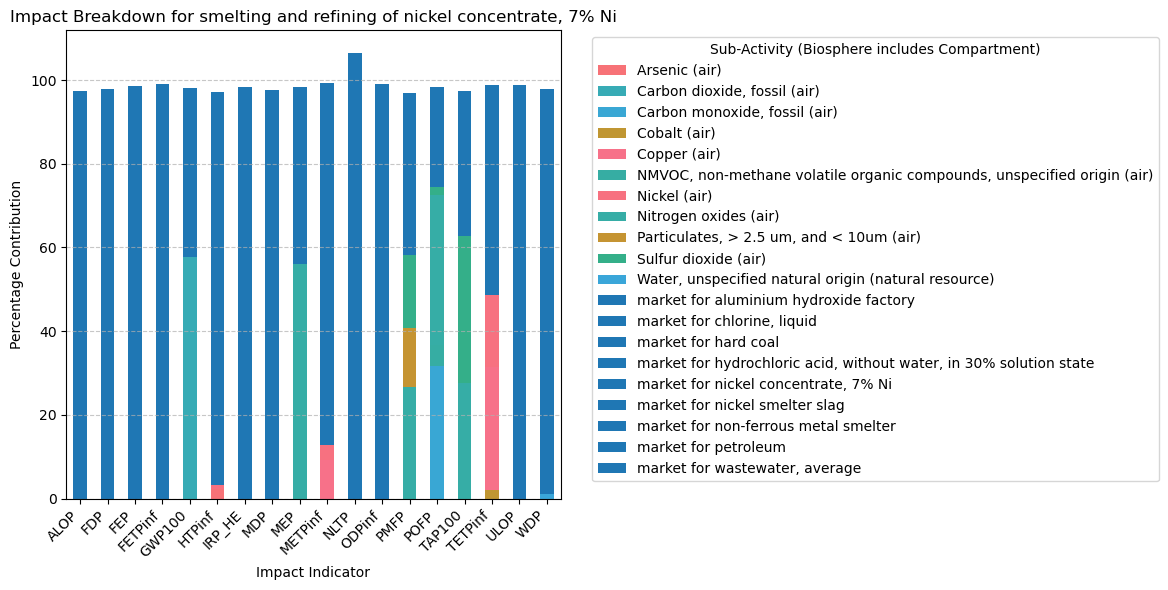

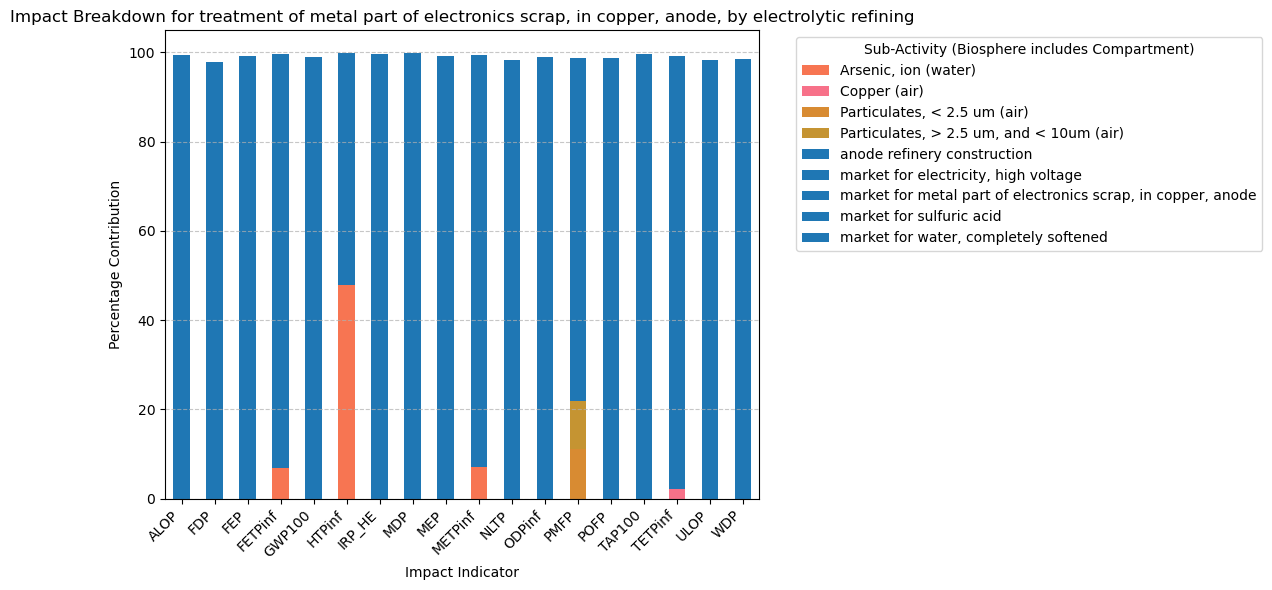

c:\Users\berna\OneDrive\Documentos\GitHub\plca-NMC-oxide-BM-PhD\plotting.py:295: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


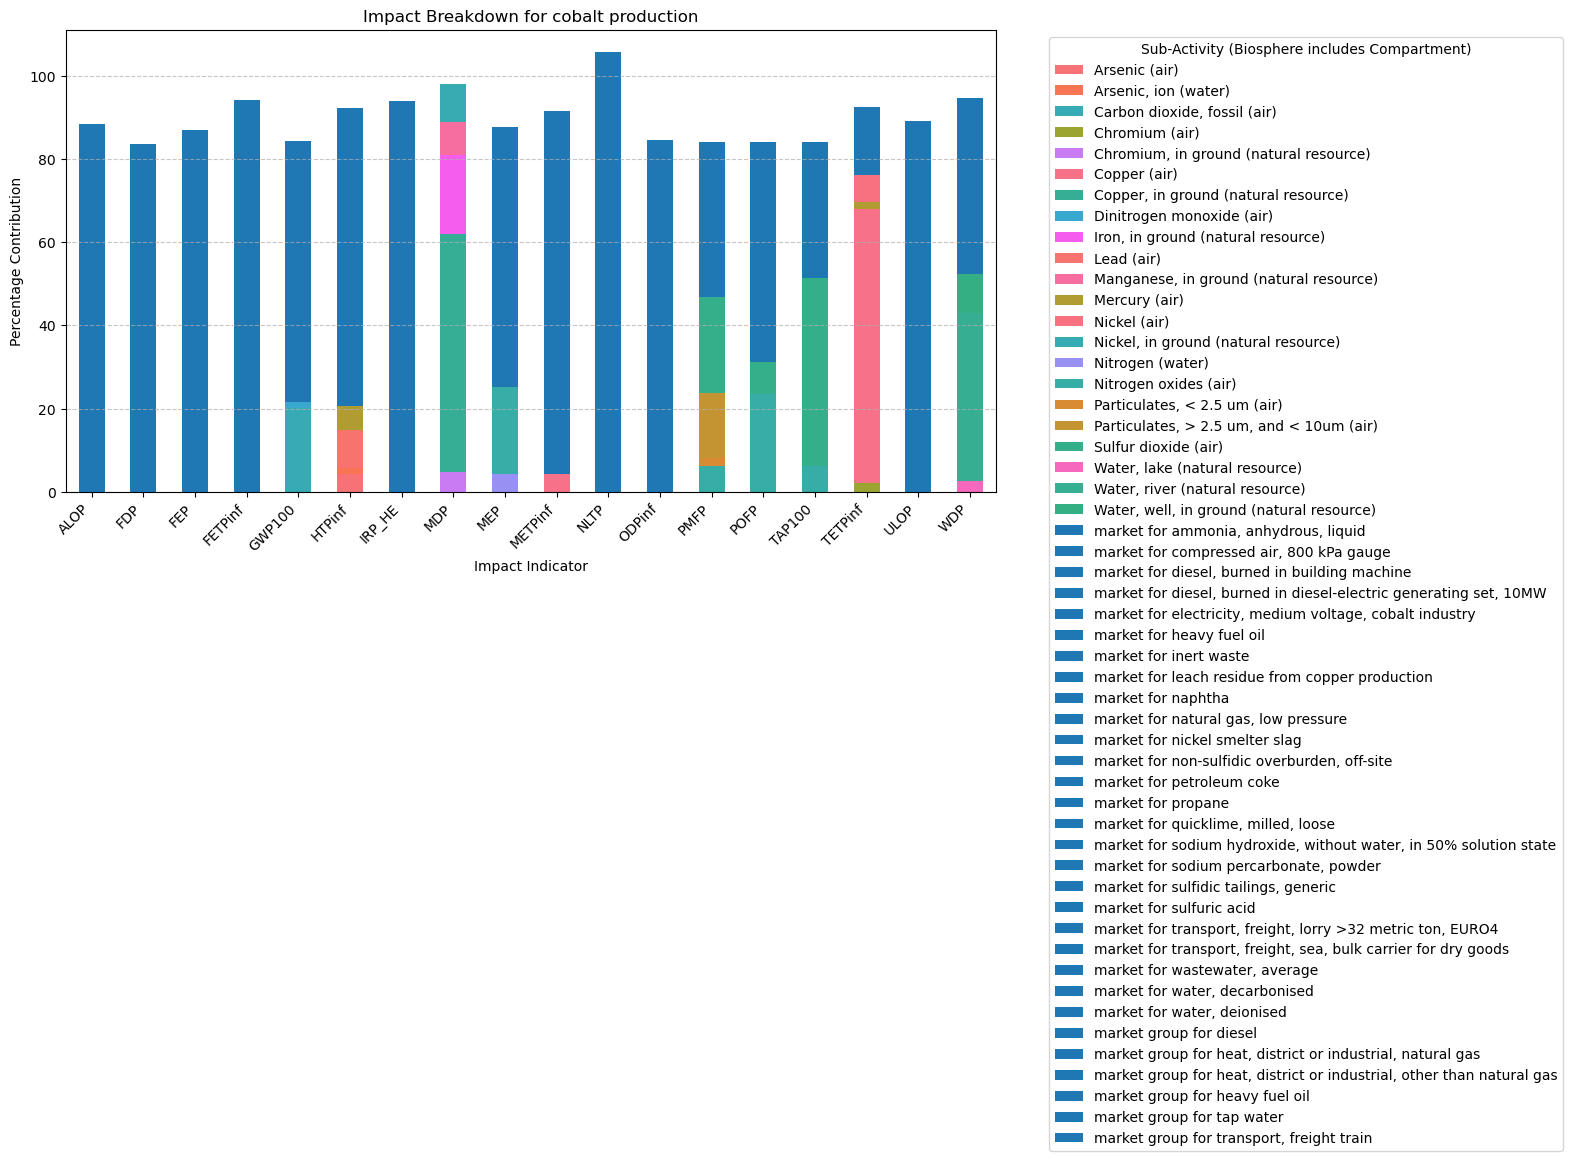

In [4]:
csv_file_path = "contribution_analysis/EFcontributions_nickel.csv"

# Run the function to generate plots for all activities with unique biosphere colors
visualize_all_activities_with_detailed_biosphere(csv_file_path)


## 3.3. Manganese subsystem

Total Activities: 2


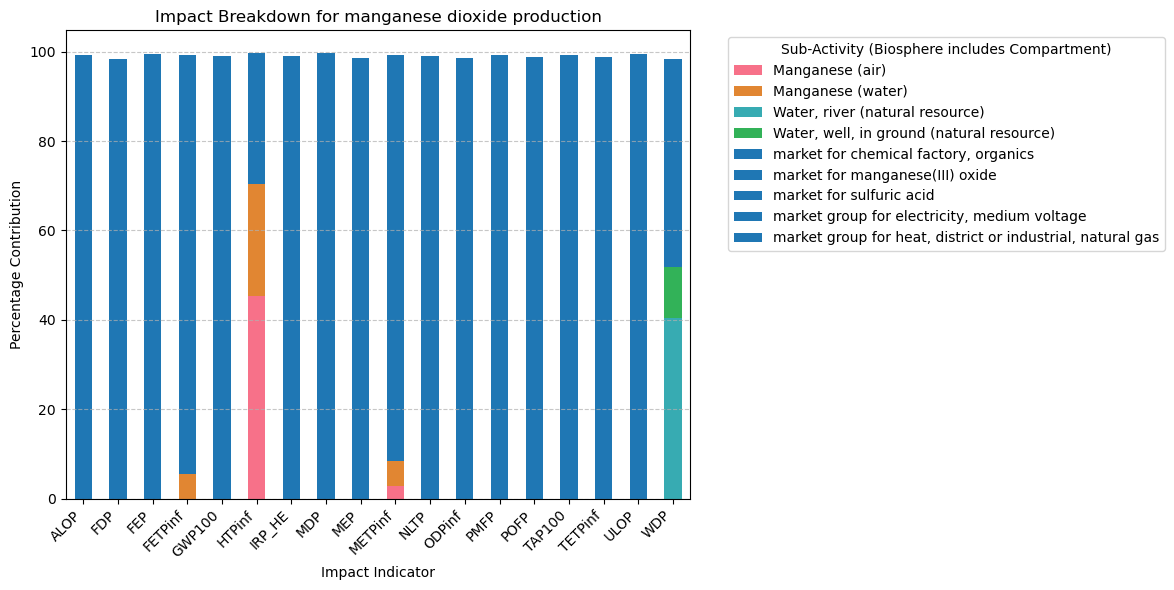

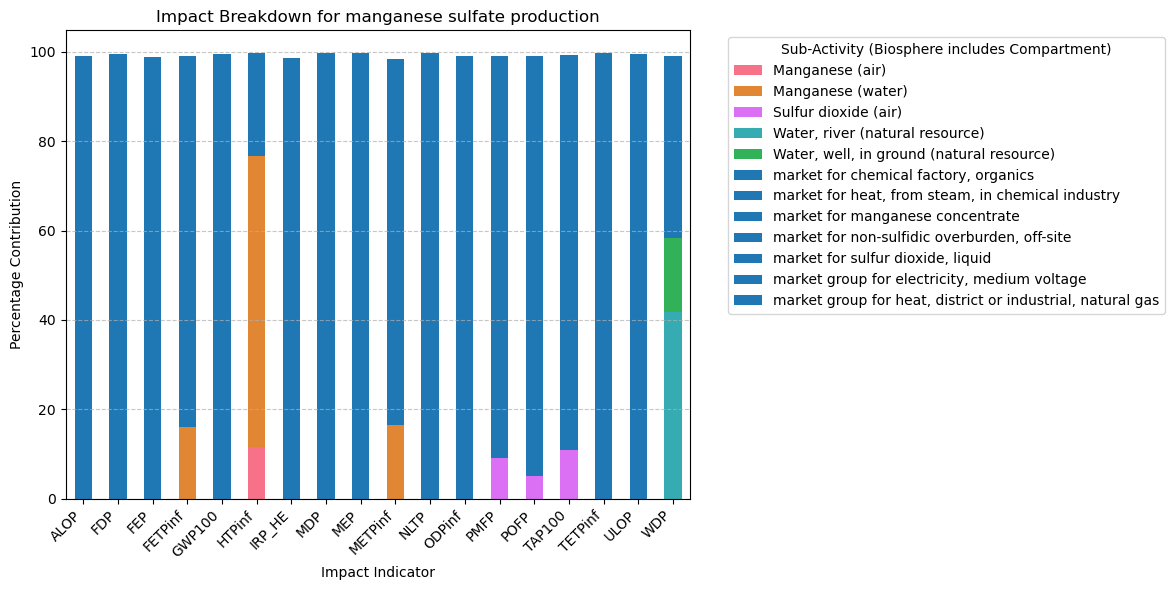

In [5]:
# Example Usage:
csv_file_path = "contribution_analysis/EFcontributions_manganese.csv"

# Run the function to generate plots for all activities with unique biosphere colors
visualize_all_activities_with_detailed_biosphere(csv_file_path)


## 3.4. NMC111 overview

Total Activities: 1


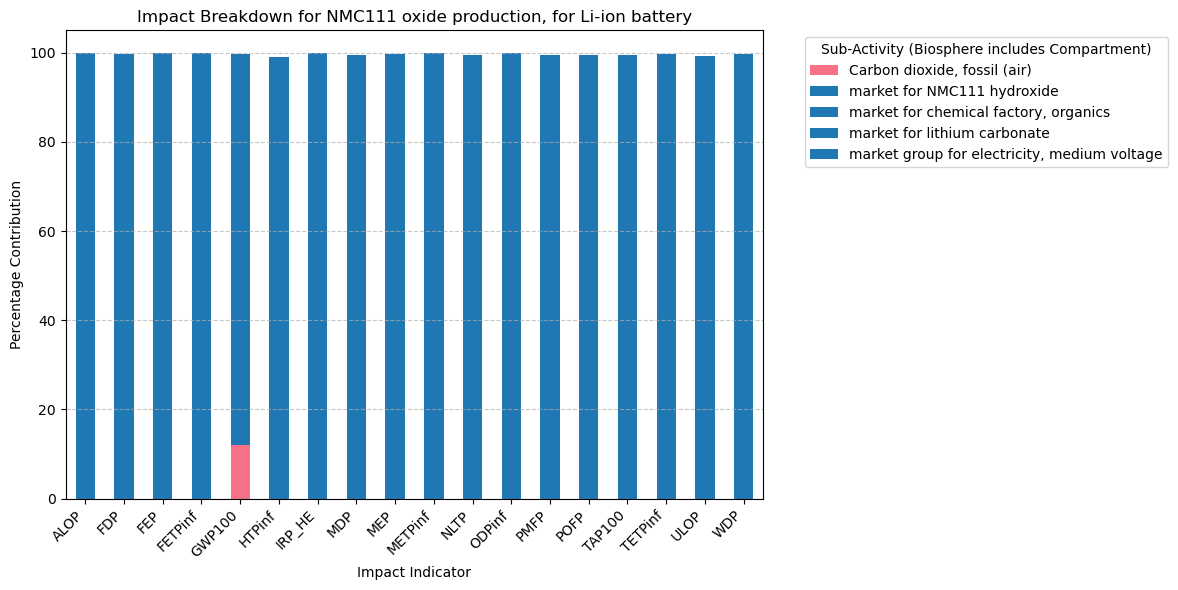

In [6]:
# Example Usage:
csv_file_path = "contribution_analysis/EFcontributions_nmcoxide.csv"

# Run the function to generate plots for all activities with unique biosphere colors
visualize_all_activities_with_detailed_biosphere(csv_file_path)


# 3. Checking individual processes over time

In [ ]:
# Function to filter and prepare data for plotting
def prepare_data_for_plot(df, activity, value_col="Score After"):
    # Filter for the specified activity
    filtered_df = df[df["Activity"] == activity]
    # Pivot data to have Years as columns and Methods as rows
    pivoted_df = filtered_df.pivot(index="Method", columns="Year", values=value_col)
    return pivoted_df.reset_index().melt(id_vars="Method", var_name="Year", value_name="Score")

In [ ]:
# Function to prepare data for heatmap
def prepare_heatmap_data(df, value_col='Score After'):
    # Pivot the dataframe to create a heatmap-friendly format
    heatmap_data = df.pivot(index='Method', columns='Year', values=value_col)
    return heatmap_data

In [ ]:
# Example usage
activity_name = 'platinum group metal mine operation, ore with high palladium content'
df_baseline = prepare_data_for_plot(ssp1_baseline_results_df, activity_name, value_col=' Score After ')
df_vsi = prepare_data_for_plot(ssp1_vsi_interpolated_results_df, activity_name, value_col=' Score After ')


In [ ]:
df_baseline = prepare_heatmap_data(df_baseline, 'Score')
df_vsi = prepare_heatmap_data(df_vsi, 'Score')

In [ ]:
df_vsi

In [ ]:
df_baseline

In [ ]:
def plot_comparison(baseline, vsi, n_rows=6, n_cols=3):
    # Reset index for easier handling
    baseline = baseline.reset_index()
    vsi = vsi.reset_index()

    # Drop the "Type" column if it exists, as it is not needed
    if "Type" in baseline.columns:
        baseline = baseline.drop(columns=["Type"])
    if "Type" in vsi.columns:
        vsi = vsi.drop(columns=["Type"])

    # Transpose data to long format for plotting
    baseline_long = baseline.melt(id_vars="Method", var_name="Year", value_name="Baseline")
    vsi_long = vsi.melt(id_vars="Method", var_name="Year", value_name="VSI")

    # Convert Year to numeric
    baseline_long["Year"] = pd.to_numeric(baseline_long["Year"], errors="coerce")
    vsi_long["Year"] = pd.to_numeric(vsi_long["Year"], errors="coerce")

    # Drop any rows where Year conversion failed
    baseline_long = baseline_long.dropna(subset=["Year"])
    vsi_long = vsi_long.dropna(subset=["Year"])

    # Merge the two dataframes for easier plotting
    merged_data = pd.merge(baseline_long, vsi_long, on=["Method", "Year"], how="inner")

    # Convert Baseline and VSI columns to numeric
    merged_data["Baseline"] = pd.to_numeric(merged_data["Baseline"], errors="coerce")
    merged_data["VSI"] = pd.to_numeric(merged_data["VSI"], errors="coerce")

    # Define the number of rows and columns for subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 18), sharex=True, sharey=False)
    axes = axes.flatten()

    # Plot each method on a separate subplot
    for i, method in enumerate(merged_data["Method"].unique()):
        # Subset the data for the current method
        subset = merged_data[merged_data["Method"] == method]
        
        # Select the corresponding subplot
        ax = axes[i]
        
        # Plot the lines for both datasets
        ax.plot(subset["Year"], subset["Baseline"], marker='o', linestyle='--', label="Baseline", color="blue")
        ax.plot(subset["Year"], subset["VSI"], marker='s', linestyle='-', label="VSI", color="orange")
        
        # Set title and labels for the subplot
        ax.set_title(str(method), fontsize=10)
        ax.set_xlabel("Year", fontsize=8)
        ax.set_ylabel("Score", fontsize=8)
        
        # Add padding to Y-axis for better visibility
        y_min = min(subset["Baseline"].min(), subset["VSI"].min())
        y_max = max(subset["Baseline"].max(), subset["VSI"].max())
        padding = (y_max - y_min) * 0.1  # 10% padding
        ax.set_ylim(y_min - padding, y_max + padding)
        
        # Add grid and adjust tick labels
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.tick_params(axis='both', labelsize=8)
        
        # Add legend to each subplot
        ax.legend(fontsize=8, loc="upper left")

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage
plot_comparison(df_baseline, df_vsi)


In [ ]:
df_baseline

In [ ]:
def plot_stacked_area(baseline, vsi):
    # Flatten the multi-level index to make 'Year' and 'Method' accessible
    baseline.columns = baseline.columns.get_level_values(0)
    vsi.columns = vsi.columns.get_level_values(0)

    # Reset index to make 'Year' a column
    baseline = baseline.reset_index()
    vsi = vsi.reset_index()

    # Melt the dataframes to convert wide format into long format
    baseline_long = baseline.melt(id_vars=["Year"], var_name="Method", value_name="Baseline")
    vsi_long = vsi.melt(id_vars=["Year"], var_name="Method", value_name="VSI")

    # Convert Year to numeric
    baseline_long["Year"] = pd.to_numeric(baseline_long["Year"], errors="coerce")
    vsi_long["Year"] = pd.to_numeric(vsi_long["Year"], errors="coerce")

    # Group by 'Year' and sum up scores across methods
    baseline_sum = baseline_long.groupby("Year")["Baseline"].sum()
    vsi_sum = vsi_long.groupby("Year")["VSI"].sum()

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.fill_between(baseline_sum.index, baseline_sum, alpha=0.5, label="Baseline", color="blue")
    ax.fill_between(vsi_sum.index, vsi_sum, alpha=0.5, label="VSI", color="orange")
    ax.set_title("Cumulative Impact Over Time", fontsize=14)
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Cumulative Score", fontsize=12)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Example usage
plot_stacked_area(df_baseline, df_vsi)


# EVERYTHING HERE IS PAST, DONE, TO BE CONFIRMED 

In [ ]:
ssp1_baseline_results_df = pd.read_csv('./outputs/combined_results/combined_results_remindSSP1_baseline.csv')
ssp1_vsi_results_df = pd.read_csv('./outputs/combined_results/combined_results_remindSSP1_VSI.csv')
ssp1_vsi_interpolated_results_df = pd.read_csv('./outputs/combined_results/combined_results_remindSSP1_VSI_interpolated.csv')

In [ ]:
activity_name = 'smelting and refining of nickel concentrate, 7% Ni'

In [ ]:
ssp1_noVSI_Ni7 = ssp1_baseline_results_df[ssp1_baseline_results_df['Activity']==activity_name]

In [ ]:
ssp1_VSI_Ni7 = ssp1_vsi_interpolated_results_df[ssp1_vsi_interpolated_results_df['Activity']==activity_name]

In [ ]:
ssp1_noVSI_Ni7['Scenario'] = 'SSP1_noVSI'
ssp1_VSI_Ni7['Scenario'] = 'SSP1_withVSI'

In [ ]:
all_data_df = pd.concat([ssp1_noVSI_Ni7, ssp1_VSI_Ni7])

In [ ]:
all_data_df

## All together

In [ ]:
# Load your datasets
ssp1_noVSI_df = pd.read_csv('./outputs/lcia/SSP1_premise_update_withoutVSI_smelting and refining of nickel concentrate, 7% Ni_CN_lcia_results_comparison.csv')
ssp1_withVSI_df = pd.read_csv('./outputs/lcia/SSP1_premise_update_withVSI_smelting and refining of nickel concentrate, 7% Ni_CN_lcia_results_comparison.csv')
ssp2_noVSI_df = pd.read_csv('./outputs/lcia/SSP2_premise_update_withoutVSI_smelting and refining of nickel concentrate, 7% Ni_CN_lcia_results_comparison.csv')
ssp2_withVSI_df = pd.read_csv('./outputs/lcia/SSP2_premise_update_withVSI_smelting and refining of nickel concentrate, 7% Ni_CN_lcia_results_comparison.csv')
ssp5_noVSI_df = pd.read_csv('./outputs/lcia/SSP5_premise_update_withoutVSI_smelting and refining of nickel concentrate, 7% Ni_CN_lcia_results_comparison.csv')
ssp5_withVSI_df = pd.read_csv('./outputs/lcia/SSP5_premise_update_withVSI_smelting and refining of nickel concentrate, 7% Ni_CN_lcia_results_comparison.csv')

# Label the scenarios
ssp1_noVSI_df['Scenario'] = 'SSP1_noVSI'
ssp1_withVSI_df['Scenario'] = 'SSP1_withVSI'
ssp2_noVSI_df['Scenario'] = 'SSP2_noVSI'
ssp2_withVSI_df['Scenario'] = 'SSP2_withVSI'
ssp5_noVSI_df['Scenario'] = 'SSP5_noVSI'
ssp5_withVSI_df['Scenario'] = 'SSP5_withVSI'

# Combine all dataframes
all_data_df = pd.concat([ssp1_noVSI_df, ssp1_withVSI_df, ssp2_noVSI_df, ssp2_withVSI_df, ssp5_noVSI_df, ssp5_withVSI_df])

In [ ]:
all_data_df

In [ ]:
# Convert 'Year' to string for easier plotting
all_data_df['Year'] = all_data_df['Year'].astype(str)

# List of scenarios for plotting order
scenarios = ['SSP1_noVSI', 'SSP1_withVSI']

# Set up the matplotlib figure with 3 rows and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 18), sharex=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each scenario and create a heatmap
for i, scenario in enumerate(scenarios):
    # Filter data for the current scenario
    scenario_data = all_data_df[all_data_df['Scenario'] == scenario]
    
    # Pivot the data to get years as columns and methods as rows
    heatmap_data = scenario_data.pivot_table(
        index='Method',
        columns='Year',
        values='Score After'
    ).fillna(0)  # Fill missing values with zeros (optional)
    
    # Create the heatmap
    sns.heatmap(
        heatmap_data,
        ax=axes[i],
        annot=True,
        fmt=".5f",
        cmap="YlGnBu",
        vmin=0, vmax=100,
        cbar=(i == 5),  # Only add color bar to the last plot for space efficiency
        cbar_kws={'label': 'Score'}
    )
    
    # Set titles and labels
    axes[i].set_title(scenario, fontsize=14)
    axes[i].set_xlabel("Year")
    axes[i].set_ylabel("Impact Assessment Method")

# Adjust layout and spacing
plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust the rect to fit cbar if needed
plt.show()


In [ ]:
# Convert 'Year' to string for easier plotting
all_data_df['Year'] = all_data_df['Year'].astype(str)

# List of scenarios for plotting order
scenarios = ['SSP1_noVSI', 'SSP1_withVSI', 'SSP2_noVSI', 'SSP2_withVSI', 'SSP5_noVSI', 'SSP5_withVSI']

# Set up the matplotlib figure with 3 rows and 2 columns, sharing y-axis within rows
fig, axes = plt.subplots(3, 2, figsize=(16, 18), sharex='none', sharey='col', gridspec_kw={'wspace': 0.05, 'hspace': 0.3})

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each scenario and create a heatmap
for i, scenario in enumerate(scenarios):
    # Filter data for the current scenario
    scenario_data = all_data_df[all_data_df['Scenario'] == scenario]
    
    # Pivot the data to get years as columns and methods as rows
    heatmap_data = scenario_data.pivot_table(
        index='Method',
        columns='Year',
        values='Score After'
    ).fillna(0)  # Fill missing values with zeros (optional)
    
    # Create the heatmap without a color bar
    sns.heatmap(
        heatmap_data,
        ax=axes[i],
        annot=True,
        fmt=".4f",
        cmap="YlGnBu",
        vmin=0, vmax=100,
        cbar=False  # Disable individual color bars
    )
    
    # Set titles and labels
    axes[i].set_title(scenario, fontsize=14)
    axes[i].set_xlabel("Year")
    
    # Remove y-axis labels for the right column
    if i % 2 == 1:
        axes[i].set_ylabel("")
        axes[i].set_yticklabels([])

# Add a single color bar to the right side of the entire figure
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap="YlGnBu", norm=plt.Normalize(0, 100)),
    ax=axes,
    orientation="vertical",
    fraction=0.02,
    pad=0.03
)
cbar.set_label("Score After")

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.95, 1])  # Make room for the color bar
plt.show()


In [ ]:
# Set up the matplotlib figure with 3 rows and 2 columns, sharing y-axis within rows
fig, axes = plt.subplots(3, 2, figsize=(16, 18), sharex='none', sharey='col', gridspec_kw={'wspace': 0.05, 'hspace': 0.3})
axes = axes.flatten()

# Loop through each scenario to create a heatmap of change over time
for i, scenario in enumerate(scenarios):
    # Filter data for the current scenario
    scenario_data = all_data_df[all_data_df['Scenario'] == scenario]

    # Pivot the data to get years as columns and methods as rows
    pivoted_data = scenario_data.pivot(index='Method', columns='Year', values='Score After')
    
    # Calculate change over time
    change_data = pivoted_data.diff(axis=1).iloc[:, 1:]  # Compute difference between years (2025 to 2030 and 2030 to 2035)
    change_data.columns = ["2025-2030", "2030-2035"]  # Rename columns to reflect the change

    # Create the heatmap for change over time
    sns.heatmap(
        change_data,
        ax=axes[i],
        annot=True,
        fmt=".1f",
        cmap="coolwarm",  # Blue-Red color map for changes
        center=0,         # Center the colormap at 0 to differentiate increase and decrease
        cbar=False        # Disable individual color bars
    )

    # Set titles and labels
    axes[i].set_title(scenario, fontsize=14)
    axes[i].set_xlabel("Change Period")
    
    # Remove y-axis labels for the right column
    if i % 2 == 1:
        axes[i].set_ylabel("")
        axes[i].set_yticklabels([])

# Add a single color bar to the right side of the entire figure
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(-100, 100)),
    ax=axes,
    orientation="vertical",
    fraction=0.02,
    pad=0.03
)
cbar.set_label("Change in Score After")

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.95, 1])  # Make room for the color bar
plt.show()


In [ ]:
# Load your datasets
ssp1_noVSI_df = pd.read_csv('./outputs/lcia/SSP1_premise_update_withoutVSI_smelting and refining of nickel concentrate, 7% Ni_CN_lcia_results_comparison.csv')
ssp1_withVSI_df = pd.read_csv('./outputs/lcia/SSP1_premise_update_withVSI_smelting and refining of nickel concentrate, 7% Ni_CN_lcia_results_comparison.csv')
ssp2_noVSI_df = pd.read_csv('./outputs/lcia/SSP2_premise_update_withoutVSI_smelting and refining of nickel concentrate, 7% Ni_CN_lcia_results_comparison.csv')
ssp2_withVSI_df = pd.read_csv('./outputs/lcia/SSP2_premise_update_withVSI_smelting and refining of nickel concentrate, 7% Ni_CN_lcia_results_comparison.csv')
ssp5_noVSI_df = pd.read_csv('./outputs/lcia/SSP5_premise_update_withoutVSI_smelting and refining of nickel concentrate, 7% Ni_CN_lcia_results_comparison.csv')
ssp5_withVSI_df = pd.read_csv('./outputs/lcia/SSP5_premise_update_withVSI_smelting and refining of nickel concentrate, 7% Ni_CN_lcia_results_comparison.csv')

# Label the scenarios
ssp1_noVSI_df['Scenario'] = 'SSP1_noVSI'
ssp1_withVSI_df['Scenario'] = 'SSP1_withVSI'
ssp2_noVSI_df['Scenario'] = 'SSP2_noVSI'
ssp2_withVSI_df['Scenario'] = 'SSP2_withVSI'
ssp5_noVSI_df['Scenario'] = 'SSP5_noVSI'
ssp5_withVSI_df['Scenario'] = 'SSP5_withVSI'

# Combine all dataframes
all_data_df = pd.concat([ssp1_noVSI_df, ssp1_withVSI_df, ssp2_noVSI_df, ssp2_withVSI_df, ssp5_noVSI_df, ssp5_withVSI_df])

# Convert 'Year' to integer for easier calculations
all_data_df['Year'] = all_data_df['Year'].astype(int)

# Sort data for consistent percentage change calculations
all_data_df = all_data_df.sort_values(by=['Scenario', 'Method', 'Year'])

# Calculate the percentage change for each year within each 'Scenario' and 'Method'
all_data_df['Percentage Change'] = all_data_df.groupby(['Scenario', 'Method'])['Score After'].apply(lambda x: x.pct_change() * 100)

# Set percentage change for the year 2025 to zero, as there's no previous year to compare to
all_data_df.loc[all_data_df['Year'] == 2025, 'Percentage Change'] = 0

# Display the resulting DataFrame with the calculated percentage changes
all_data_df[['Scenario', 'Method', 'Year', 'Score After', 'Percentage Change']].head(10)

In [ ]:
# Convert 'Year' to string for easier plotting
all_data_df['Year'] = all_data_df['Year'].astype(str)

# List of scenarios for plotting order
scenarios = ['SSP1_noVSI', 'SSP1_withVSI', 'SSP2_noVSI', 'SSP2_withVSI', 'SSP5_noVSI', 'SSP5_withVSI']

# Set up the matplotlib figure with 3 rows and 2 columns, sharing y-axis within rows
fig, axes = plt.subplots(3, 2, figsize=(12, 18), sharex='none', sharey='col', gridspec_kw={'wspace': 0.05, 'hspace': 0.3})

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each scenario and create a heatmap
for i, scenario in enumerate(scenarios):
    # Filter data for the current scenario
    scenario_data = all_data_df[all_data_df['Scenario'] == scenario]
    
    # Pivot the data to get years as columns and methods as rows
    heatmap_data = scenario_data.pivot_table(
        index='Method',
        columns='Year',
        values='Percentage Change'
    ).fillna(0)  # Fill missing values with zeros (optional)
    
    # Create the heatmap with a diverging color map, centered at zero
    sns.heatmap(
        heatmap_data,
        ax=axes[i],
        annot=True,
        fmt=".1f",
        cmap="RdYlGn_r",  # Red-Yellow-Green colormap for diverging data
        center=0,       # Center colormap at zero to differentiate positive/negative values
        cbar=False      # Disable individual color bars
    )
    
    # Set titles and labels
    axes[i].set_title(scenario, fontsize=14)
    axes[i].set_xlabel("Year")
    
    # Remove y-axis labels for the right column
    if i % 2 == 1:
        axes[i].set_ylabel("")
        axes[i].set_yticklabels([])

# Add a single color bar to the right side of the entire figure
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap="RdYlGn_r", norm=plt.Normalize(-100, 100)),  # Centered color bar range
    ax=axes,
    orientation="vertical",
    fraction=0.02,
    pad=0.03
)
cbar.set_label("Percentage Change in Score After (%)")

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.95, 1])  # Make room for the color bar
plt.show()


# TESTING - WORKING HEY

## Nickel

### 7p

In [ ]:
#ssp_baseline_noVSI_results_df = pd.read_csv('./outputs/lcia/SSP1_baseline_noVSI_smelting and refining of nickel concentrate, 7% Ni_CN_lcia_results_comparison.csv')
#ssp_baseline_withVSI_results_df = pd.read_csv('./outputs/lcia/SSP1_baseline_withVSI_smelting and refining of nickel concentrate, 7% Ni_CN_lcia_results_comparison.csv')

ssp1_noVSI_df = pd.read_csv('./outputs/lcia/SSP1_premise_update_withoutVSI_smelting and refining of nickel concentrate, 7% Ni_CN_lcia_results_comparison.csv')
ssp1_withVSI_df = pd.read_csv('./outputs/lcia/SSP1_premise_update_withVSI_smelting and refining of nickel concentrate, 7% Ni_CN_lcia_results_comparison.csv')

ssp2_noVSI_df = pd.read_csv('./outputs/lcia/SSP2_premise_update_withoutVSI_smelting and refining of nickel concentrate, 7% Ni_CN_lcia_results_comparison.csv')
ssp2_withVSI_df = pd.read_csv('./outputs/lcia/SSP2_premise_update_withVSI_smelting and refining of nickel concentrate, 7% Ni_CN_lcia_results_comparison.csv')

ssp5_noVSI_df = pd.read_csv('./outputs/lcia/SSP5_premise_update_withoutVSI_smelting and refining of nickel concentrate, 7% Ni_CN_lcia_results_comparison.csv')
ssp5_withVSI_df = pd.read_csv('./outputs/lcia/SSP5_premise_update_withVSI_smelting and refining of nickel concentrate, 7% Ni_CN_lcia_results_comparison.csv')


#ssp_baseline_noVSI_results_df['Scenario'] = 'Baseline_noVSI'
#ssp_baseline_withVSI_results_df['Scenario'] = 'Baseline_withVSI'
ssp1_noVSI_df['Scenario'] = 'SSP1_noVSI'
ssp1_withVSI_df['Scenario'] = 'SSP1_withVSI'

ssp2_noVSI_df['Scenario'] = 'SSP2_noVSI'
ssp2_withVSI_df['Scenario'] = 'SSP2_withVSI'

ssp5_noVSI_df['Scenario'] = 'SSP5_noVSI'
ssp5_withVSI_df['Scenario'] = 'SSP5_withVSI'

In [ ]:
def str_to_tuple(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return x

# Convert 'Method' column in each DataFrame
ssp1_noVSI_df['Method'] = ssp1_noVSI_df['Method'].apply(str_to_tuple)
ssp1_withVSI_df['Method'] = ssp1_withVSI_df['Method'].apply(str_to_tuple)

ssp2_noVSI_df['Method'] = ssp2_noVSI_df['Method'].apply(str_to_tuple)
ssp2_withVSI_df['Method'] = ssp2_withVSI_df['Method'].apply(str_to_tuple)

ssp5_noVSI_df['Method'] = ssp5_noVSI_df['Method'].apply(str_to_tuple)
ssp5_withVSI_df['Method'] = ssp5_withVSI_df['Method'].apply(str_to_tuple)

In [ ]:
# Combine the DataFrames
combined_df = pd.concat([ssp1_noVSI_df, ssp1_withVSI_df, ssp2_noVSI_df, ssp2_withVSI_df, ssp5_noVSI_df, ssp5_withVSI_df], ignore_index=True)

In [ ]:
combined_df['Year'] = combined_df['Year'].astype(int)
combined_df['Score After'] = pd.to_numeric(combined_df['Score After'], errors='coerce')

In [ ]:
combined_df

In [ ]:
combined_df.to_csv('test.csv')

## One method

In [ ]:
# Define the method to visualize
target_method = ('ReCiPe Midpoint (H)', 'climate change', 'GWP100')

# Filter the combined DataFrame for the target method
method_df = combined_df[combined_df['Method'] == target_method]


In [ ]:
# Check if the Baseline scenario has the same values across years
baseline_method_df = method_df[method_df['Scenario'] == 'Baseline_noVSI']
print(baseline_method_df[['Year', 'Score After']])

# If the scores are the same, we can proceed

In [ ]:
# Pivot the data for plotting
plot_df = method_df.pivot_table(
    index='Year',
    columns='Scenario',
    values='Score After'
).reset_index()

# Sort the DataFrame by 'Year'
plot_df = plot_df.sort_values('Year').reset_index(drop=True)

# Display the prepared DataFrame
print(plot_df)


In [ ]:
sns.set(style='whitegrid', context='talk')

In [ ]:
# Melt the DataFrame for Seaborn
melted_df = plot_df.melt(id_vars='Year', value_vars=['Baseline_noVSI','Baseline_withVSI','SSP1_noVSI','SSP1_withVSI'],
                         var_name='Scenario', value_name='Score After')



# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=melted_df, x='Year', y='Score After', hue='Scenario', style='Scenario',
             markers=True, dashes=False)

# Customize the Baseline scenario to be a dashed line
baseline_line = plt.gca().lines[2]  # Assuming the third line is Baseline
baseline_line.set_linestyle('--')

# Add titles and labels
plt.title('Change in LCIA Score Over Time for Method:\n' + ' - '.join(target_method))
plt.xlabel('Year')
plt.ylabel('LCIA Score (Score After)')
plt.legend(title='Scenario', loc='best')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


### All methods

In [ ]:
# Get a list of unique methods
methods = combined_df['Method'].unique()

for method in methods:
    # Filter data for the method
    method_df = combined_df[combined_df['Method'] == method]
    
    # Pivot the data
    plot_df = method_df.pivot_table(
        index='Year',
        columns='Scenario',
        values='Score After'
    ).reset_index()
    
    # Melt the DataFrame
    melted_df = plot_df.melt(id_vars='Year', var_name='Scenario', value_name='Score After')
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=melted_df, x='Year', y='Score After', hue='Scenario', style='Scenario',
                 markers=True)
    
    # Customize the Baseline line
    lines = plt.gca().get_lines()
    for line in lines:
        label = line.get_label()
        if label == 'Baseline':
            line.set_linestyle('--')
    
    # Add titles and labels
    plt.title('Change in LCIA Score Over Time for Method:\n' + ' - '.join(method))
    plt.xlabel('Year')
    plt.ylabel('LCIA Score (Score After)')
    plt.legend(title='Scenario', loc='best')
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


In [ ]:
# Prepare data for FacetGrid
melted_df_all = combined_df.pivot_table(
    index='Year',
    columns=['Scenario', 'Method'],
    values='Score After'
).reset_index()

# Melt the DataFrame
melted_df_all = melted_df_all.melt(
    id_vars='Year',
    var_name=['Scenario', 'Method'],
    value_name='Score After'
)

# Drop NaN values
melted_df_all = melted_df_all.dropna()

# Convert 'Method' column from string to tuple if necessary
def str_to_tuple(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return x

if melted_df_all['Method'].dtype == 'object':
    melted_df_all['Method'] = melted_df_all['Method'].apply(str_to_tuple)

# Create the FacetGrid with increased size and fewer columns
g = sns.FacetGrid(
    melted_df_all,
    col='Method',
    hue='Scenario',
    col_wrap=2,        # Adjust as needed
    height=5,          # Increase the height of each subplot
    aspect=1.5,        # Adjust the aspect ratio
    sharey=False,
    sharex=True        # Share x-axis to ensure consistent x-ticks
)

# Map the data to the FacetGrid
g.map(plt.plot, 'Year', 'Score After', marker='o')

# Set x-ticks for all subplots
g.set(xticks=[2025, 2030, 2035])

# Customize each subplot
for ax in g.axes.flatten():
    # Get the method from the title
    method_title = ax.get_title().split(' = ')[-1]
    method = ast.literal_eval(method_title)  # Convert string back to tuple

    # Create a wrapped title
    method_str = ' - '.join(method)
    method_wrapped = '\n'.join(textwrap.wrap(method_str, width=40))  # Adjust width as needed

    # Set the wrapped title
    ax.set_title(method_wrapped)
    ax.set_xlabel('Year')
    ax.set_ylabel('LCIA Score (Score After)')
    ax.grid(True)

    # Ensure x-ticks are set
    ax.set_xticks([2025, 2030, 2035])
    ax.set_xticklabels([2025, 2030, 2035])

# Add an overall title to the plot
g.fig.suptitle('Change in LCIA Scores Over Time for Different Scenarios', fontsize=16)

# Adjust the space at the top to make room for the suptitle
g.fig.subplots_adjust(top=0.92)

# Add a single legend at the top
# Remove the legend from the FacetGrid if it exists
if g._legend:
    g._legend.remove()

# Create a custom legend
from matplotlib.lines import Line2D

# Get unique scenarios and assign colors
scenarios = melted_df_all['Scenario'].unique()
palette = sns.color_palette(n_colors=len(scenarios))
scenario_colors = dict(zip(scenarios, palette))

# Create legend handles
legend_handles = [
    Line2D(
        [0], [0],
        color=scenario_colors[scenario],
        marker='o',
        linestyle='',
        label=scenario
    ) for scenario in scenarios
]

# Add the legend to the figure
g.fig.legend(
    handles=legend_handles,
    title='Scenario',
    loc='upper center',
    # bbox_to_anchor=(0.5, 1.05),
    ncol=len(scenarios)
)

# Adjust layout to make room for the legend and title
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import textwrap

# Get unique methods
methods = combined_df['Method'].unique()

# Determine the grid size
n_methods = len(methods)
n_cols = 3  # Adjust based on how many columns you want
n_rows = math.ceil(n_methods / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))

# Flatten axes array for easy indexing
axes = axes.flatten()

for i, method in enumerate(methods):
    ax = axes[i]
    # Filter data for the method
    df_method = combined_df[combined_df['Method'] == method]
    
    # Pivot the data to get Scenarios vs. Years
    pivot_df = df_method.pivot(index='Scenario', columns='Year', values='Score After')
    
    # Create the heatmap
    sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap='viridis', ax=ax)
    
    # Set titles and labels
    method_str = ' - '.join(method)
    method_wrapped = '\n'.join(textwrap.wrap(method_str, width=30))
    ax.set_title(method_wrapped, fontsize=10)
    ax.set_xlabel('Year')
    ax.set_ylabel('Scenario')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
combined_df

In [ ]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap

# Assuming combined_df is already prepared

# Get unique methods
methods = combined_df['Method'].unique()

# Determine the grid size
n_methods = len(methods)
n_cols = 2  # Reduce the number of columns for larger subplots
n_rows = math.ceil(n_methods / n_cols)

# Increase the figure size multipliers
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))

# Flatten axes array for easy indexing
axes = axes.flatten()

for i, method in enumerate(methods):
    ax = axes[i]
    # Filter data for the method
    df_method = combined_df[combined_df['Method'] == method]
    
    # Pivot the data to get Scenarios vs. Years
    pivot_df = df_method.pivot(index='Scenario', columns='Year', values='Score After')
    
    # Create the heatmap with adjusted parameters
    sns.heatmap(pivot_df, annot=True, fmt=".5f", cmap='Greens', ax=ax,
                annot_kws={"size": 12},  # Increase font size of annotations
                cbar_kws={"shrink": 0.8})  # Adjust colorbar size if needed
    
    # Set titles and labels with increased font size and wrapping
    method_str = ' - '.join(method)
    method_wrapped = '\n'.join(textwrap.wrap(method_str, width=50))
    ax.set_title(method_wrapped, fontsize=14)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Scenario', fontsize=12)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to make room for titles
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
